# Detecção de Fraude Com Pytorch

[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/joaofranca13/CESAR-Fraud-Detection/blob/main/pytorch_fraud_detection_training.ipynb)

## Dataset

O conjunto de dados contém registros de transações realizados por cartões de crédito em setembro de 2013 por titulares de cartões europeus.

Temos 284.807 transações, das quais apenas 0,172% corresponde à classe positiva (fraudes). Ou seja, é um dataset altamente desbalanceado.

As variáveis independentes são resultantes de uma transformação PCA, com exceção de "Time" e "Amount". O coluna 'Class' é a variável dependente e assume valor 1 em caso de fraude e 0 caso contrário.

## Dependências

In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data_utils
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Carregando os dados

In [2]:
od.download(
    "https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud"
)

Skipping, found downloaded files in "./creditcardfraud" (use force=True to force download)


In [3]:
df = pd.read_csv("./creditcardfraud/creditcard.csv")

In [4]:
df.shape

(284807, 31)

In [5]:
df.head().T

,0,1,2,3,4
Time,0.000000,0.000000,1.000000,1.000000,2.000000
V1,-1.359807,1.191857,-1.358354,-0.966272,-1.158233
V2,-0.072781,0.266151,-1.340163,-0.185226,0.877737
V3,2.536347,0.166480,1.773209,1.792993,1.548718
V4,1.378155,0.448154,0.379780,-0.863291,0.403034
V5,-0.338321,0.060018,-0.503198,-0.010309,-0.407193
V6,0.462388,-0.082361,1.800499,1.247203,0.095921
V7,0.239599,-0.078803,0.791461,0.237609,0.592941
V8,0.098698,0.085102,0.247676,0.377436,-0.270533
V9,0.363787,-0.255425,-1.514654,-1.387024,0.817739


## Análise Exploratória

Text(0, 0.5, 'Frequência')

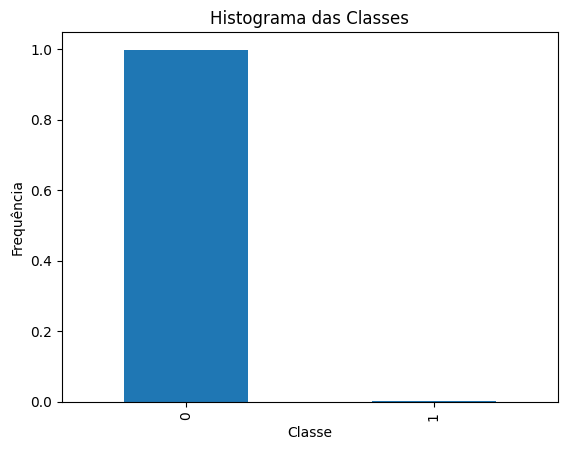

In [6]:
round(df.groupby("Class")["Class"].count()/df.shape[0],4).plot(kind="bar")
plt.title("Histograma das Classes")
plt.xlabel("Classe")
plt.ylabel("Frequência")

In [7]:
pd.set_option('float_format', '{:f}'.format)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.000000,94813.859575,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.000000,0.000000,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.000000,0.000000,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.000000,-0.000000,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.000000,0.000000,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.000000,0.000000,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.000000,0.000000,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.000000,-0.000000,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.000000,0.000000,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.000000,-0.000000,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


<AxesSubplot: >

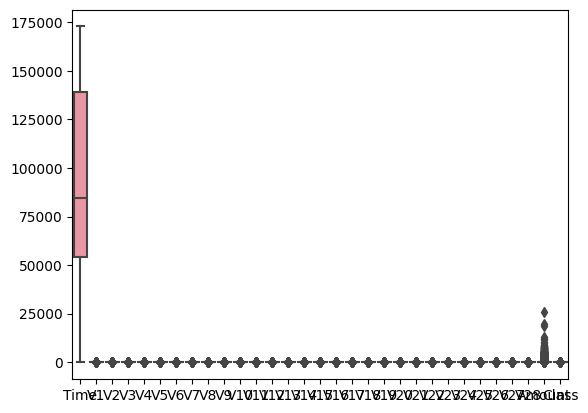

In [8]:
sns.boxplot(data=df)

Para as variáveis que não foram transformadas por PCA (Time e Amount), será necessário a normalização

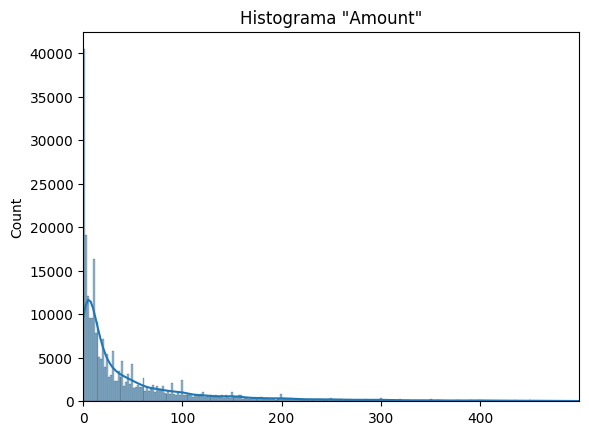

In [9]:
amount = np.array(df['Amount'])
amount = amount[amount < 500]

ax = sns.histplot(amount, kde=True)
ax.set_xlim([min(amount), max(amount)])
ax.set_title('Histograma "Amount"')
plt.show()

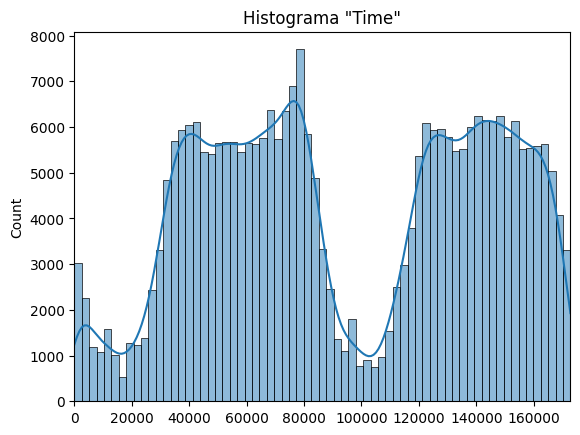

In [10]:
time = np.array(df['Time'])

ax = sns.histplot(time, kde=True)
ax.set_xlim([min(time), max(time)])
ax.set_title('Histograma "Time"')
plt.show()

In [11]:
df["Timestamp"] = df["Time"] % (60 * 60 * 24)

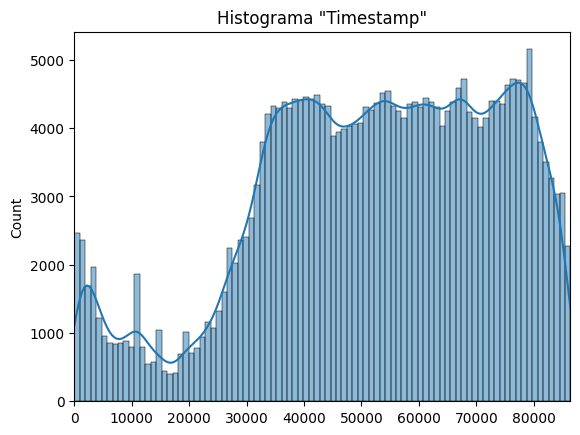

In [12]:
timestamp = np.array(df['Timestamp'])

ax = sns.histplot(timestamp, kde=True)
ax.set_xlim([min(timestamp), max(timestamp)])
ax.set_title('Histograma "Timestamp"')
plt.show()

## Scalling

In [13]:
rob_scaler = RobustScaler() #Scale features using statistics that are robust to outliers.

df['scaled_amount'] = rob_scaler.fit_transform(df[['Amount']])
df['scaled_time'] = rob_scaler.fit_transform(df[['Time']])
df['scaled_timestamp'] = rob_scaler.fit_transform(df[['Timestamp']])

df.drop(['Time','Amount', 'Timestamp'], axis=1, inplace=True)

<AxesSubplot: >

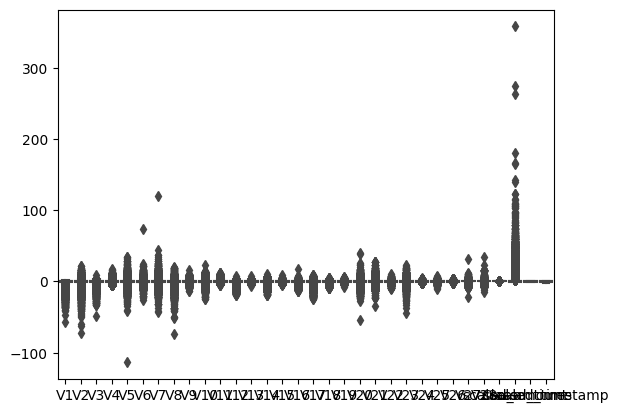

In [14]:
sns.boxplot(data=df)

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,284807.000000,0.000000,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.000000,0.000000,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.000000,-0.000000,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.000000,0.000000,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.000000,0.000000,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.000000,0.000000,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.000000,-0.000000,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.000000,0.000000,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.000000,-0.000000,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995
V10,284807.000000,0.000000,1.088850,-24.588262,-0.535426,-0.092917,0.453923,23.745136


## Under-sampling 

Visto que o dataset é altamente desbalanceado, é necessário realizar algum método de resampling, neste caso o Under-sampling.

O objetivo é coletar menos amostras da classe 0 de forma a balancear a quantidade de observações entre as classes.


In [16]:
df_cp = df.copy()
df_cp = df_cp.sample(frac=1, random_state=0) #Shuffling

fraud_df = df[df["Class"] == 1]
legit_df = df[df["Class"] == 0][:(len(fraud_df)*2)]

balanced_df = pd.concat([fraud_df, legit_df])
balanced_df = balanced_df.sample(frac=1, random_state=0)

Text(0, 0.5, 'Frequência')

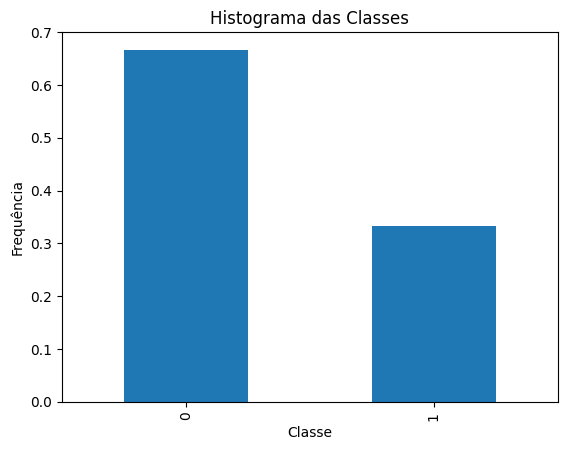

In [17]:
round(balanced_df.groupby("Class")["Class"].count()/balanced_df.shape[0],4).plot(kind="bar")
plt.title("Histograma das Classes")
plt.xlabel("Classe")
plt.ylabel("Frequência")

In [18]:
X = balanced_df.drop(['Class'], axis=1)
y = balanced_df['Class']

print(X.shape)
print(y.shape)

(1476, 31)
(1476,)


Agora temos a proporção de 0: 67% e 1: 33%

## Treinamento Rede Neural com Pytorch

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train = torch.from_numpy(np.array(X_train)).float()
y_train = torch.from_numpy(np.array(y_train)).float()
X_test = torch.from_numpy(np.array(X_test)).float()
y_test = torch.from_numpy(np.array(y_test)).float()

In [21]:
FEATURE_NUM = X_train.shape[1]

### Rede Neural

![nn](./assets/nn.svg)

In [22]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(FEATURE_NUM, 16),
            nn.ReLU(),
            nn.Linear(16, 18),
            nn.ReLU(),
            nn.Linear(18, 20),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(20, 24),
            nn.ReLU(),
            nn.Linear(24, 1),
            nn.Sigmoid()
            
        )     
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=31, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=18, bias=True)
    (3): ReLU()
    (4): Linear(in_features=18, out_features=20, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=20, out_features=24, bias=True)
    (8): ReLU()
    (9): Linear(in_features=24, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [23]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            pred = model(Variable(X.cuda()))
        else:
            pred = model(Variable(X))
        pred = pred.numpy()
        pred = pred.flatten()
        pred = np.around(pred, 0)
        return pred         

In [24]:
if use_gpu:
    y_pred = model(Variable(X_train[0:3].cuda()))
else:
    y_pred = model(Variable(X_train[0:3]))
print(y_pred)
print(F.softmax(y_pred, dim=1))

tensor([[0.5013],
        [0.5007],
        [0.4971]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.]], grad_fn=<SoftmaxBackward0>)


In [25]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)

In [26]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        pred = torch.flatten(pred)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Training Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [27]:
def test(dataloader, model, loss_fn):
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = predict(model, X)
        acc = accuracy_score(y.numpy(), pred)

    print(f"Test Accuracy: {round(acc, 4)*100}%")

In [28]:
batch_size = 64

#Creating datasets:
training_data = data_utils.TensorDataset(X_train, y_train)
test_data = data_utils.TensorDataset(X_test, y_test)


# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 31])
Shape of y: torch.Size([64]) torch.float32


In [29]:
epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    scheduler.step()
print("Done!")

Epoch 1
-------------------------------
Training Loss: 0.719145  [    0/ 1328]
Test Accuracy: 95.0%
Epoch 2
-------------------------------
Training Loss: 0.203282  [    0/ 1328]
Test Accuracy: 100.0%
Epoch 3
-------------------------------
Training Loss: 0.019530  [    0/ 1328]
Test Accuracy: 100.0%
Epoch 4
-------------------------------
Training Loss: 0.015883  [    0/ 1328]
Test Accuracy: 100.0%
Epoch 5
-------------------------------
Training Loss: 0.010828  [    0/ 1328]
Test Accuracy: 100.0%
Epoch 6
-------------------------------
Training Loss: 0.005539  [    0/ 1328]
Test Accuracy: 100.0%
Epoch 7
-------------------------------
Training Loss: 0.006983  [    0/ 1328]
Test Accuracy: 100.0%
Epoch 8
-------------------------------
Training Loss: 0.002376  [    0/ 1328]
Test Accuracy: 100.0%
Epoch 9
-------------------------------
Training Loss: 0.000916  [    0/ 1328]
Test Accuracy: 100.0%
Epoch 10
-------------------------------
Training Loss: 0.000460  [    0/ 1328]
Test Accurac

## Resultados

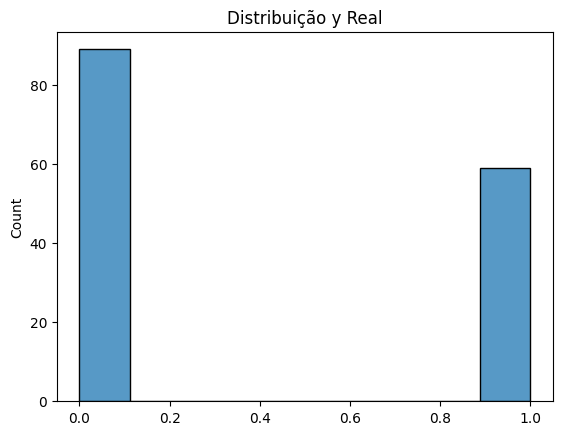

In [36]:
ax = sns.histplot(y_test)
ax.set_title('Distribuição y Real')
plt.show()

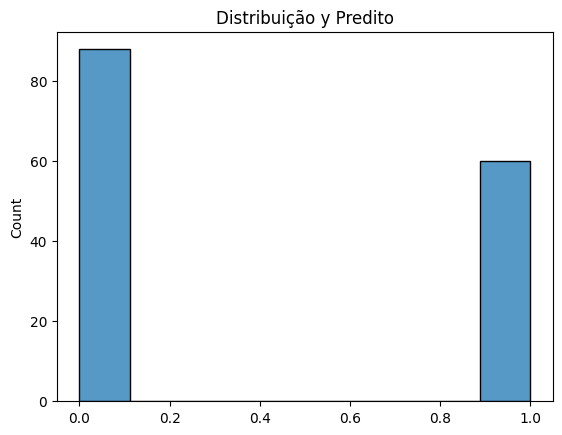

In [35]:
y_pred = predict(model, X_test)
ax = sns.histplot(y_pred)
ax.set_title('Distribuição y Predito')
plt.show()

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99        89
         1.0       0.98      1.00      0.99        59

    accuracy                           0.99       148
   macro avg       0.99      0.99      0.99       148
weighted avg       0.99      0.99      0.99       148



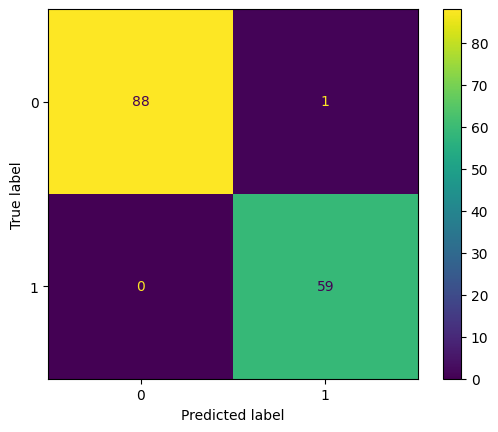

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [49]:
torch.save(model.state_dict(), "./model/credit_card_fraud_detec.pt")

## Referências

- https://github.com/vcasadei/Redes-Neurais-CESAR-School/blob/2022.01/4%20-%20Redes%20Neurais/4.10-credit_card_fraud_detection_kaggle_pytorch.ipynb

- https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

- https://www.kaggle.com/code/joparga3/in-depth-skewed-data-classif-93-recall-acc-now